In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import random
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [37]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
class NPZDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # e.g., "dataset/train/" or "dataset/val/"
        self.transform = transform  # Optional data transformations
        self.classes = ['no', 'sphere', 'vort'] 
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}  # Maps class names to indices (e.g., 'no': 0, 'sphere': 1, 'vort': 2)
        self.samples = self._load_samples()  # List of (file_path, label) pairs

    def _load_samples(self):
        samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)  # e.g., "dataset/train/no/"
            for file_name in os.listdir(cls_dir):
                if file_name.endswith('.npy'):  # Only process .npy files
                    file_path = os.path.join(cls_dir, file_name)
                    samples.append((file_path, self.class_to_idx[cls_name]))
        return samples

    def __len__(self):
        return len(self.samples)  # Total number of samples

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]  
        data = np.load(file_path)  
        data = torch.from_numpy(data).float()  
        if self.transform:
            data = self.transform(data)  
        return data, label  

In [ ]:
train_dir = "dataset/train/"  
val_dir = "dataset/val/"     

Category: no
Sample file: dataset/train/no/531.npy
Image shape: (1, 150, 150)
Adjusted image shape: (150, 150)

Category: sphere
Sample file: dataset/train/sphere/531.npy
Image shape: (1, 150, 150)
Adjusted image shape: (150, 150)

Category: vort
Sample file: dataset/train/vort/531.npy
Image shape: (1, 150, 150)
Adjusted image shape: (150, 150)



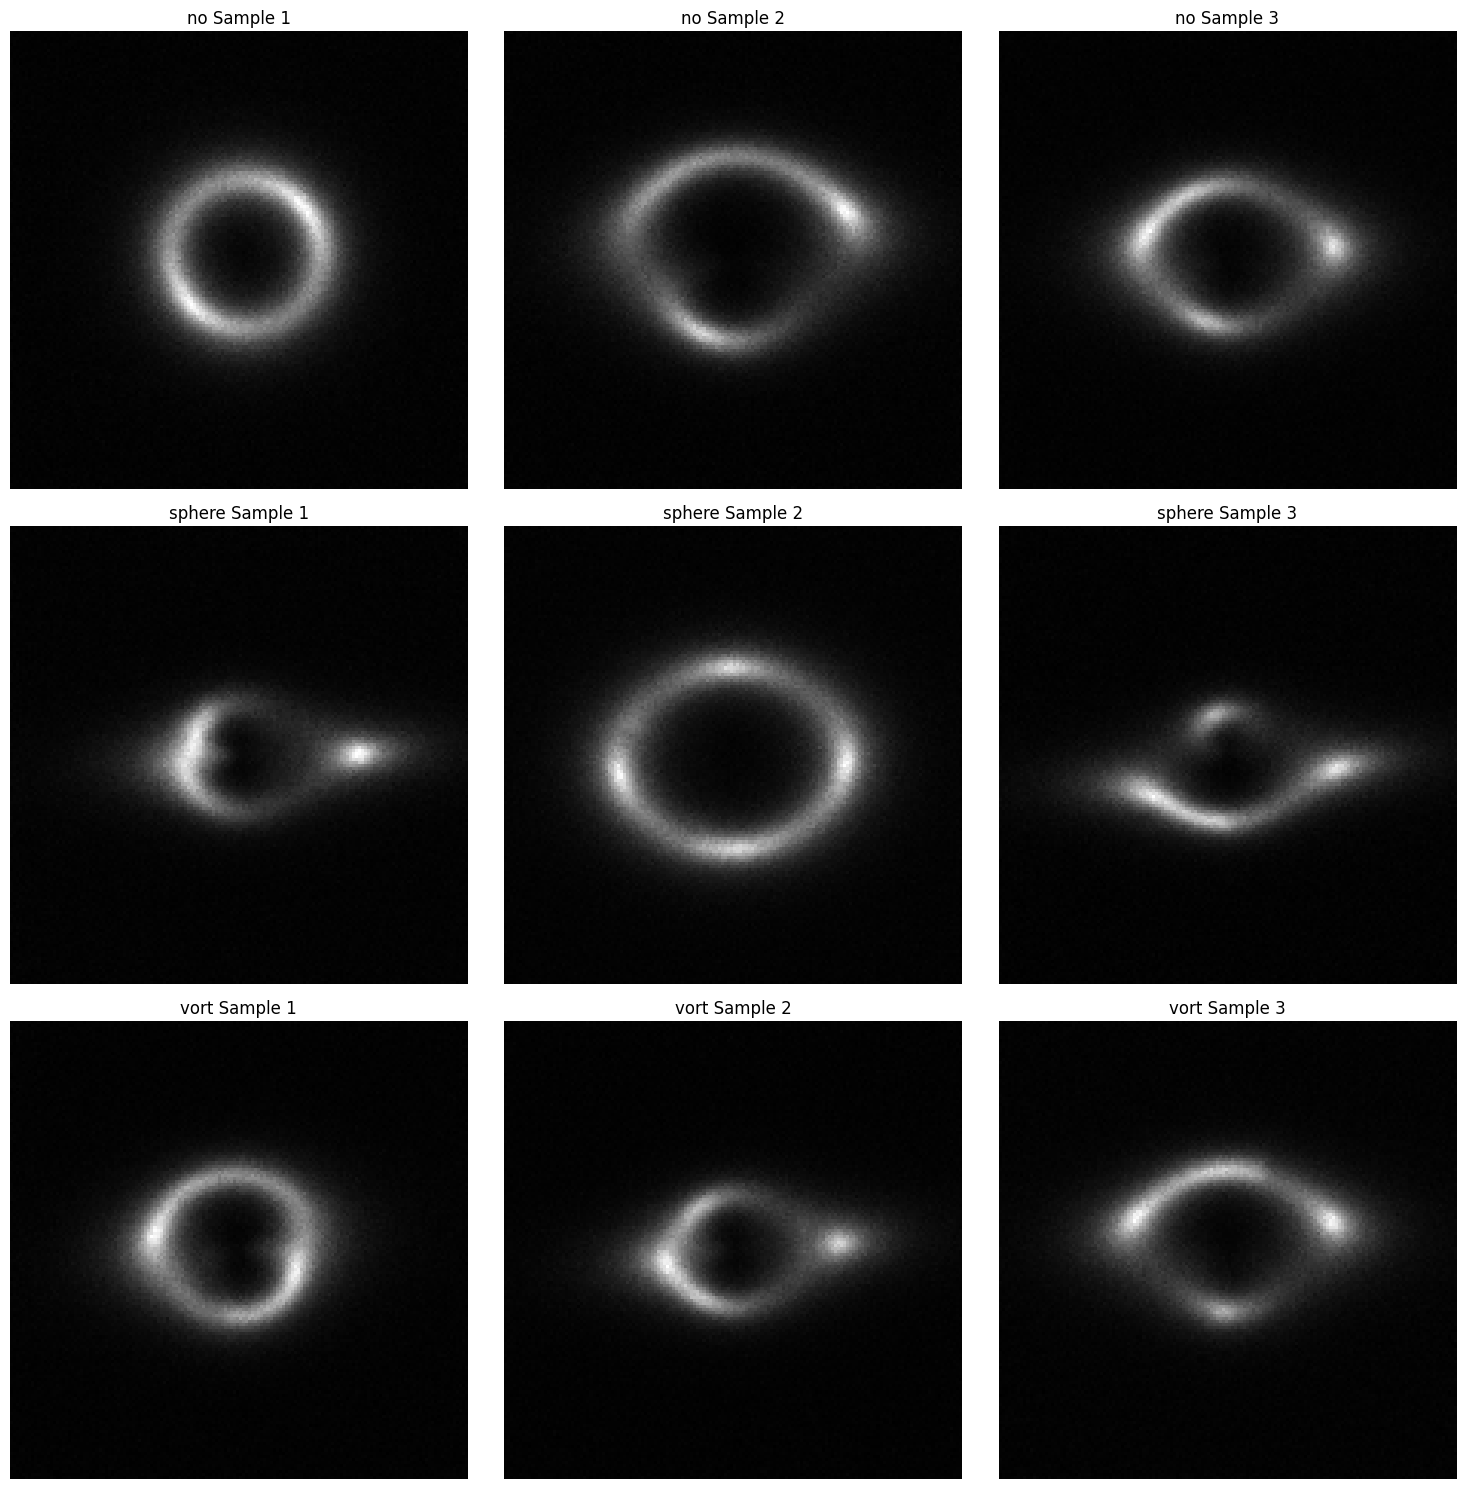

In [ ]:
# Categories to preview
categories = ['no', 'sphere', 'vort']
num_images_per_class = 3 

# Set up the subplot grid: 3 rows (one per class), 3 columns (images per class)
fig, axes = plt.subplots(nrows=len(categories), ncols=num_images_per_class, figsize=(15, 5 * len(categories)))

# Loop through each category and display images
for i, category in enumerate(categories):
    # Get the list of .npy files for this category
    category_dir = os.path.join(train_dir, category)
    image_files = [f for f in os.listdir(category_dir) if f.endswith('.npy')]

    # Select the first `num_images_per_class` files (or fewer if not enough files)
    image_files = image_files[:min(num_images_per_class, len(image_files))]

    # Load and display each image
    for j, image_file in enumerate(image_files):
        # Load the .npy file
        file_path = os.path.join(category_dir, image_file)
        image_data = np.load(file_path)  # Shape: (1, 150, 150)
        image_2d = image_data[0]  # Shape: (150, 150)

        # Plot the image
        ax = axes[i, j]
        ax.imshow(image_2d, cmap='gray')
        ax.set_title(f"{category} Sample {j+1}")
        ax.axis('off')

        # Print shape info for the first image in each category
        if j == 0:
            print(f"Category: {category}")
            print(f"Sample file: {file_path}")
            print(f"Image shape: {image_data.shape}")
            print(f"Adjusted image shape: {image_2d.shape}\n")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [41]:
transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.Lambda(lambda x: x.rot90(random.randint(0, 3), [1, 2])), 
    # transforms.Lambda(lambda x: x / x.max()),
    transforms.Lambda(lambda x: x.float())  # Ensure float type
])

In [42]:
# Load full train and val datasets
full_train_dataset = NPZDataset(root_dir=train_dir, transform=transform)
val_dataset = NPZDataset(root_dir=val_dir, transform=None)

In [43]:
# Split train into 90% train and 10% test
train_size = int(0.9 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size
train_dataset, test_dataset = random_split(full_train_dataset, [train_size, test_size])

In [44]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check sizes
print(f"Full train dataset size: {len(full_train_dataset)}")
print(f"Train split size: {len(train_dataset)} (90%)")
print(f"Test split size: {len(test_dataset)} (10%)")
print(f"Validation size: {len(val_dataset)}")

Full train dataset size: 30000
Train split size: 27000 (90%)
Test split size: 3000 (10%)
Validation size: 7500


Train

In [45]:
def count_parameters(model: nn.Module) -> float:
    num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_parameters_m = num_parameters / 1e6
    print(f"The model has {num_parameters_m:.2f}M trainable parameters.")
    return num_parameters_m

In [46]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Input: 1 channel (grayscale lensing images)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        # Adjust the linear layer size based on your image dimensions
        self.fc1 = nn.Linear(128 * 18 * 18, 256)  # For 150x150 input images
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 3)  # 3 output classes: no, sphere, vort

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 18 * 18)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Raw logits
        return x


In [ ]:
# Define the BasicBlock for ResNet-18
class BasicBlock(nn.Module):
    expansion = 1  # No expansion in ResNet-18's BasicBlock

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # First conv layer: 3x3 conv, stride may vary
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second conv layer: 3x3 conv, stride=1
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # Downsample for residual connection if needed
        self.stride = stride

    def forward(self, x):
        identity = x  # Save input for residual connection

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Apply downsample to identity if needed (e.g., when channels or size change)
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # Add residual connection
        out = F.relu(out)
        return out

# Define the ResNet-18 model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 64  # Initial number of channels after first conv

        # Initial conv layer: 7x7 conv, stride 2, followed by max pooling
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Input: 1 channel 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define the four layers of ResNet-18
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)  
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to 1x1
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        # If stride != 1 or input channels != output channels, we need to downsample the identity
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        # First block in the layer (may have stride > 1 for downsampling)
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        # Add remaining blocks (stride=1)
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate ResNet-18
def ResNet18(num_classes=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

In [48]:
# Initialize model, loss, and optimizer
device = torch.device("cuda")
# model = CNN().to(device)
model = ResNet18(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [49]:
checkpoint_dir = "/workspace_1/checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)
epochloss_dir = "/workspace_1/epoch_loss/"
os.makedirs(epochloss_dir, exist_ok=True)

In [50]:
# Training loop with validation and checkpointing
num_epochs = 150
checkpoint_interval = 5  # Save every x epochs
best_val_acc = 0.0  # Track the best validation accuracy
best_model_path = os.path.join(checkpoint_dir, "best_model.pth")

In [51]:
# Load the best model if it exists
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_val_acc = checkpoint['val_accuracy']
    print(f"Loaded best model with Val Accuracy: {best_val_acc:.2f}%")
else:
    print("No best model found, starting from scratch.")

No best model found, starting from scratch.


In [52]:
# Optionally, load the latest checkpoint to resume training (uncomment if needed)

# # Function to find the latest checkpoint
# def find_latest_checkpoint(checkpoint_dir):
#     checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_") and f.endswith(".pth")]
#     if not checkpoints:
#         return None
#     latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("_epoch_")[1].split(".pth")[0]))
#     return os.path.join(checkpoint_dir, latest_checkpoint)

# latest_checkpoint_path = find_latest_checkpoint(checkpoint_dir)
# if latest_checkpoint_path:
#     print(f"Resuming training from latest checkpoint: {latest_checkpoint_path}")
#     checkpoint = torch.load(latest_checkpoint_path, map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#     start_epoch = checkpoint['epoch'] + 1
#     best_val_acc = checkpoint['val_accuracy']
#     print(f"Resuming from epoch {start_epoch} with Val Accuracy: {best_val_acc:.2f}%")
# else:
#     print("No checkpoint found, starting from epoch 1.")

In [53]:
def save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler, train_loss, val_loss, val_acc):
    """Saves a checkpoint with the model, optimizer, scheduler, and training metrics."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
    }, checkpoint_path)
    print(f"Saved checkpoint to {checkpoint_path}")

def train_model(model, train_loader, val_loader, n_epochs, optimizer, scheduler, criterion, device, checkpoint_dir, epochloss_dir, checkpoint_interval=5):
    best_val_acc = 0.0
    best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
    
    # Load best model if exists
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        best_val_acc = checkpoint['val_accuracy']
        print(f"Loaded best model with Val Accuracy: {best_val_acc:.2f}%")
    else:
        print("Starting from scratch.")
    
    metrics = {
        'train_loss': [], 
        'val_loss': [], 
        'val_acc': []
    }

    epochloss_path = os.path.join(epochloss_dir, "val_loss.txt")

    for epoch in range(n_epochs):
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        metrics['train_loss'].append(avg_train_loss)
        metrics['val_loss'].append(avg_val_loss)
        metrics['val_acc'].append(val_acc)

        # Save validation loss to file
        with open(epochloss_path, "a") as f:
            f.write(f"{epoch+1},{avg_val_loss:.4f}\n")

        # Update the learning rate
        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{n_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]}")

        # Save a checkpoint at the specified interval
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
            save_checkpoint(checkpoint_path, epoch + 1, model, optimizer, scheduler, avg_train_loss, avg_val_loss, val_acc)

        # Save the best model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(best_model_path, epoch + 1, model, optimizer, scheduler, avg_train_loss, avg_val_loss, val_acc)
            print(f"New best model saved with Val Accuracy: {val_acc:.2f}%")
    
    return metrics
    

In [54]:

num_parameters = count_parameters(model)

The model has 11.17M trainable parameters.


In [55]:
# Train
metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=num_epochs,  # Adjust as needed
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=device,
    checkpoint_dir=checkpoint_dir,
    epochloss_dir=epochloss_dir,
    checkpoint_interval=100  # Save checkpoint every 100 epochs
)


Starting from scratch.
Epoch [1/150]
Train Loss: 1.1223, Train Acc: 33.18%
Val Loss: 1.1003, Val Acc: 33.32%
Learning Rate: 0.006
Saved checkpoint to /workspace_1/checkpoint/best_model.pth
New best model saved with Val Accuracy: 33.32%
Epoch [2/150]
Train Loss: 1.0994, Train Acc: 33.28%
Val Loss: 1.0987, Val Acc: 33.33%
Learning Rate: 0.006
Saved checkpoint to /workspace_1/checkpoint/best_model.pth
New best model saved with Val Accuracy: 33.33%
Epoch [3/150]
Train Loss: 1.0994, Train Acc: 32.93%
Val Loss: 1.0992, Val Acc: 33.33%
Learning Rate: 0.006
Epoch [4/150]
Train Loss: 1.0994, Train Acc: 33.60%
Val Loss: 1.0986, Val Acc: 33.95%
Learning Rate: 0.006
Saved checkpoint to /workspace_1/checkpoint/best_model.pth
New best model saved with Val Accuracy: 33.95%
Epoch [5/150]
Train Loss: 1.0996, Train Acc: 33.15%
Val Loss: 1.1002, Val Acc: 33.39%
Learning Rate: 0.006
Epoch [6/150]
Train Loss: 1.0995, Train Acc: 33.26%
Val Loss: 1.0989, Val Acc: 33.33%
Learning Rate: 0.006
Epoch [7/150]
Tra

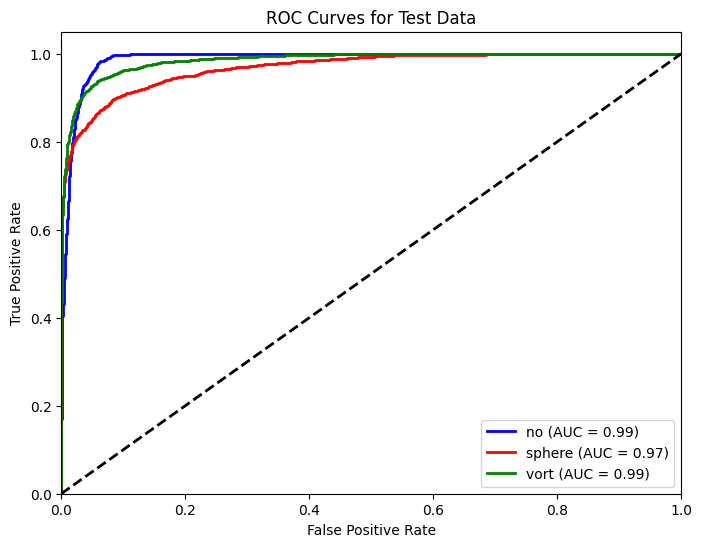

AUC for no: 0.99
AUC for sphere: 0.97
AUC for vort: 0.99


In [58]:
# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Binarize labels for multi-class ROC
n_classes = 3
y_test = label_binarize(all_labels, classes=[0, 1, 2])
fpr, tpr, roc_auc = {}, {}, {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
class_names = ['no', 'sphere', 'vort']  # Adjust based on your dataset
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Test Data')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores
for i, class_name in enumerate(class_names):
    print(f"AUC for {class_name}: {roc_auc[i]:.2f}")